In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
batch_size = 64
lr = 1e-4

# Number of Training epochs
nepoch = 10

# The size of the Latent Vector
latent_size = 128
root = "../data"

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [10]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

train_set = Datasets.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)
    # We use the mean of the KL Divergence instead of the sum because it is easier to compare
    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

    # Tune the "strength" of KL Divergence
    loss = recon_loss + 0.1 * kl_loss
    return loss

In [12]:
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            channels_in, channels_out, kernel_size=3, stride=2, padding=1
        )
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(
            channels_out, channels_out, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(channels_out)
        self.conv3 = nn.Conv2d(
            channels_in, channels_out, kernel_size=3, stride=2, padding=1
        )  # This is the skip connection. Skip connection is used to help the network learn faster by skipping some layers and directly connecting the input to the output

    def forward(self, x):
        x_skip = self.conv3(x)  # Skip connection
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.conv2(x) + x_skip  # Add the skip connection
        return F.elu(self.bn2(x))


class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(channels_in)

        self.conv1 = nn.Conv2d(
            channels_in, channels_in, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(channels_in)

        self.conv2 = nn.Conv2d(
            channels_in, channels_out, kernel_size=3, stride=1, padding=1
        )

        self.conv3 = nn.Conv2d(
            channels_in, channels_out, kernel_size=3, stride=1, padding=1
        )
        self.up_nn = nn.Upsample(
            scale_factor=2, mode="nearest"
        )  # Upsample the input. This means that we will double the size of the input

    def forward(self, x_in):
        x = F.elu(self.bn1(x_in))
        x_skip = self.up_nn(self.conv3(x))
        x = self.up_nn(F.elu(self.bn2(self.conv1(x))))

        return self.conv2(x) + x_skip

In [13]:
class Encoder(nn.Module):
    def __init__(self, channels, ch: int = 32, z: int = 32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, ch, kernel_size=3, stride=1, padding=1)

        self.conv_block1 = DownBlock(ch, ch)
        self.conv_block2 = DownBlock(ch, ch * 2)
        self.conv_block3 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernel is the same size as the feature map
        # (in practice it's the same thing)
        self.conv_mu = nn.Conv2d(ch * 4, z, kernel_size=4, stride=1)
        self.conv_logvar = nn.Conv2d(ch * 4, z, kernel_size=4, stride=1)

    # This function will sample from the latent space
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        x = self.sample(mu, logvar)

        return x, mu, logvar


class Decoder(nn.Module):
    def __init__(self, channels, ch: int = 32, z: int = 32):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, kernel_size=4, stride=1)
        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_block3 = UpBlock(ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = F.elu(self.conv_block3(x))
        return torch.tanh(self.conv_out(x))

In [14]:
class VAE(nn.Module):
    def __init__(self, channel_in, ch: int = 16, z: int = 32):
        super(VAE, self).__init__()
        self.encoder = Encoder(channel_in, ch, z)
        self.decoder = Decoder(channel_in, ch, z)

    def forward(self, x):
        encoded, mu, logvar = self.encoder(x)

        if self.training:
            x = self.decoder(encoded)
        else:
            x = self.decoder(mu)

        return x, mu, logvar

In [15]:
# Get a test image
test_images, _ = next(iter(test_loader))
test_images.shape

torch.Size([64, 1, 32, 32])

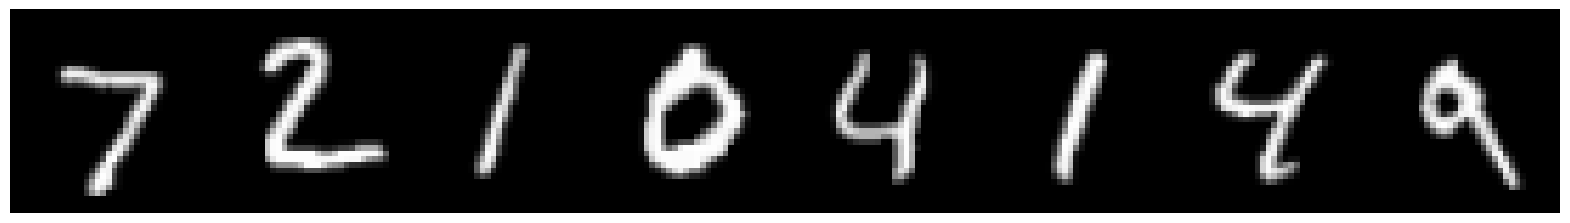

In [17]:
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [18]:
vae_net = VAE(channel_in=1, z=latent_size).to(device)
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
loss_log = []
train_loss = 0

In [19]:
recon_data, mu, logvar = vae_net(test_images.to(device))
mu.shape, logvar.shape

(torch.Size([64, 128, 1, 1]), torch.Size([64, 128, 1, 1]))

In [20]:
vae_net.train()
for epoch in tqdm(range(nepoch)):
    for i, (data, _) in enumerate(train_loader):
        image = data.to(device)

        # Forward pass
        recon_data, mu, logvar = vae_net(image)

        # Calculate the loss
        loss = vae_loss(recon_data, image, mu, logvar)

        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()

        # Training step
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [05:33<00:00, 33.35s/it]


Text(0.5, 1.0, 'VAE Loss')

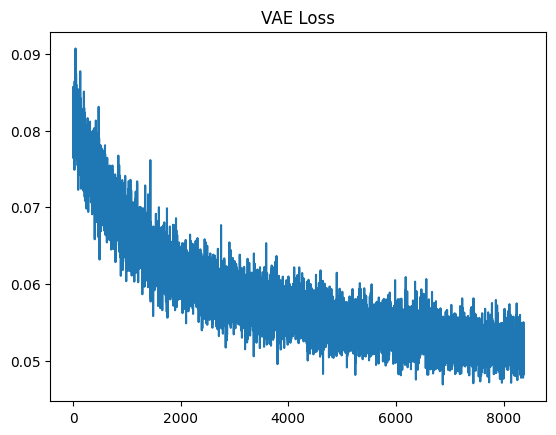

In [21]:
plt.plot(loss_log[1000:])
plt.title("VAE Loss")

In [22]:
vae_net.eval()
recon_data, mu, logvar = vae_net(test_images.to(device))

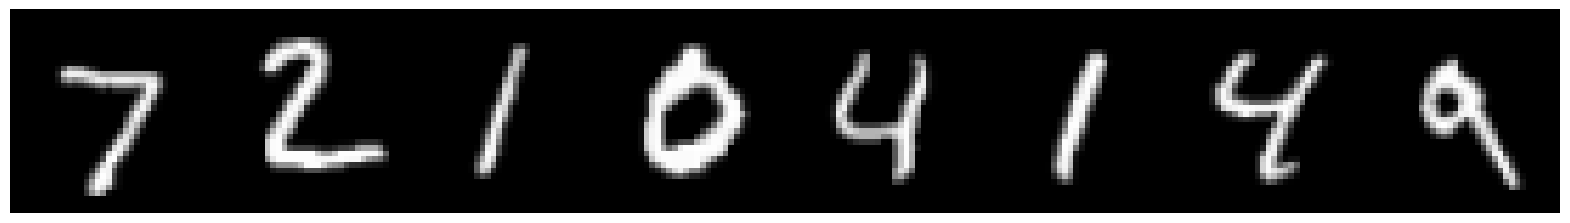

In [25]:
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

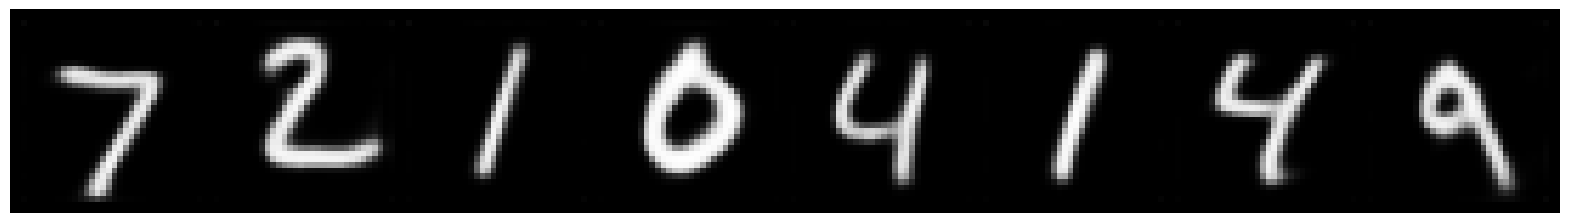

In [26]:
# Reconstruct the images
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(recon_data.cpu().detach()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

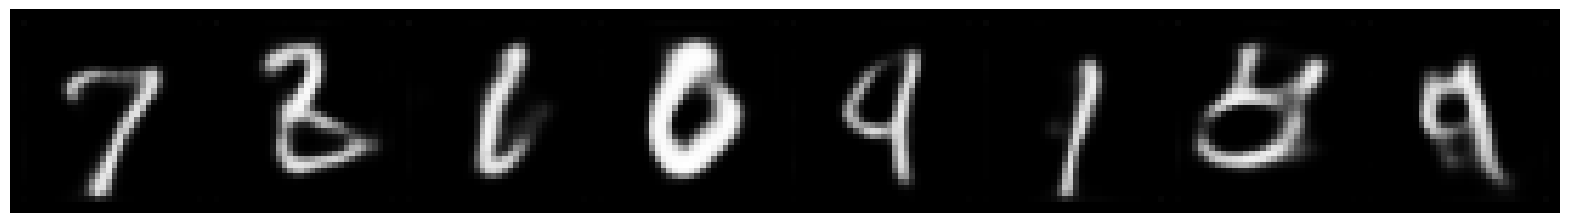

In [27]:
# Random permutation of the latent space
rand_samp = vae_net.decoder(mu + 1 * torch.randn_like(mu)).cpu().detach()
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(rand_samp[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

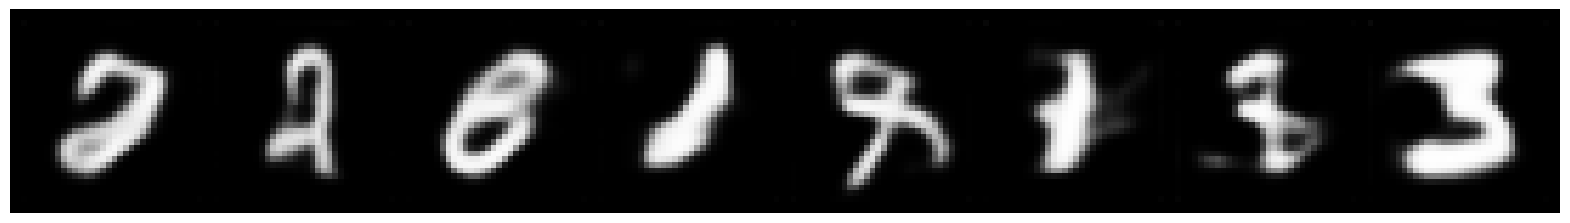

In [63]:
# Random permutation of the latent space
rand_samp = vae_net.decoder(torch.randn_like(mu)).cpu().detach()
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(rand_samp[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Interpolation in Latent Space

Now that we've trained our VAE we can explore the "MNIST Latent Space" it has created.
We first use our validation images and class labels to find the mean latent vector for each class

In [76]:
# Class means is a matrix of size (10, latent_size) where each row is the mean of the latent vectors of each class in the training set
class_means = torch.zeros((10, latent_size)).to(device)

vae_net.eval()
with torch.inference_mode():
    for i, (images, labels) in enumerate(train_loader):
        recon_data, mu, logvar = vae_net(images.to(device))

        # For each batch sum up the latent vectors of the same class
        # We use one hot encoding to get the class of each image, matmul is used to multiply the one hot encoding with the latent vector
        class_matrix = F.one_hot(labels, num_classes=10).float().to(device)
        class_means += torch.matmul(class_matrix.T, mu.squeeze())
        
# In the validation set each class has 1000 images so to find the mean vectors we divide by 1000
class_means /= 1000
class_means, class_means.shape

(tensor([[-0.1713, -1.1498,  0.1218,  ...,  0.1781,  0.1365,  0.4547],
         [-0.3205, -1.3493,  0.0870,  ...,  0.0205, -0.1387, -2.9182],
         [-0.2546,  1.3547,  0.1448,  ..., -0.2286,  0.1612,  2.3451],
         ...,
         [-0.1610, -0.1462,  0.2267,  ...,  0.0411, -0.0262, -1.7762],
         [-0.2302,  0.5573,  0.3393,  ..., -0.0793,  0.0436, -5.8210],
         [-0.2764, -1.2302,  0.2029,  ...,  0.1380, -0.2222, -3.3219]],
        device='mps:0'),
 torch.Size([10, 128]))

In [70]:
# Reshape the mean classes to the appropriate shape
class_means = class_means.view(10, latent_size, 1, 1)

# We only need to pass the latent vectors through our decoder
recon_means = vae_net.decoder(class_means.to(device))
class_means.shape, recon_means.shape

(torch.Size([10, 128, 1, 1]), torch.Size([10, 1, 32, 32]))

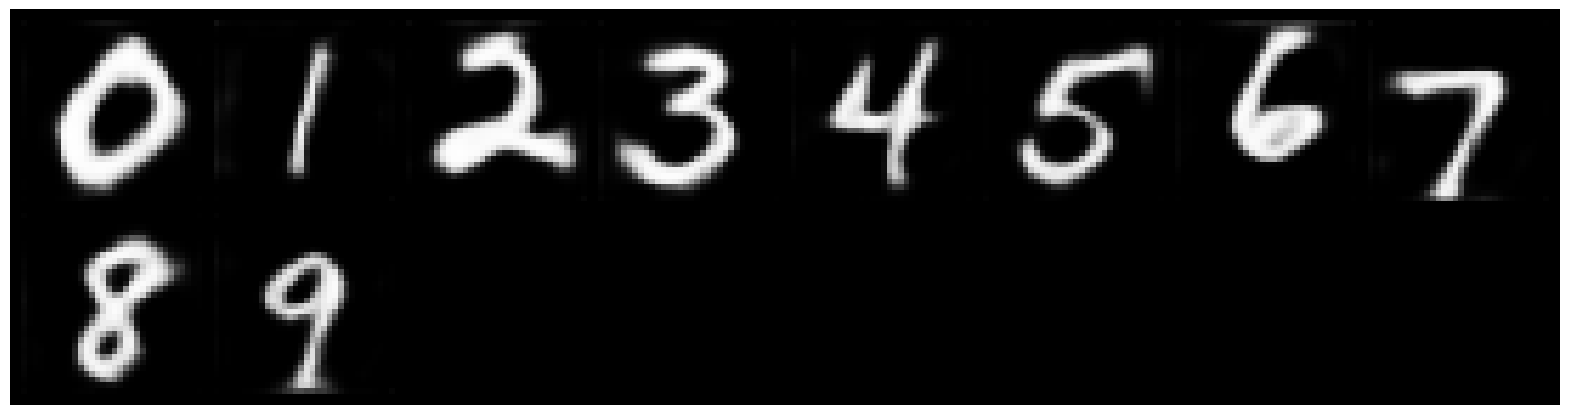

In [68]:
# Plot class means
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(recon_means.detach().cpu(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [40]:
# Interpolate between two class means
# Pick the 2 classes to move between
start_class = 4
end_class = 7

# Number of interpolation steps
num_steps = 100
steps = torch.linspace(0, 1, num_steps).to(device)

# Get the vector pointing from one class to the other
diff_vector = class_means[end_class] - class_means[start_class]
diff_vector.shape

torch.Size([128, 1, 1])

In [41]:
# Take "num_steps" from the "start_class" to the "end_class" along the "diff_vector"
latent_steps = class_means[start_class] + (
    steps.view(num_steps, 1, 1, 1) * diff_vector.view(1, latent_size, 1, 1)
)
recon_steps = vae_net.decoder(latent_steps.to(device))

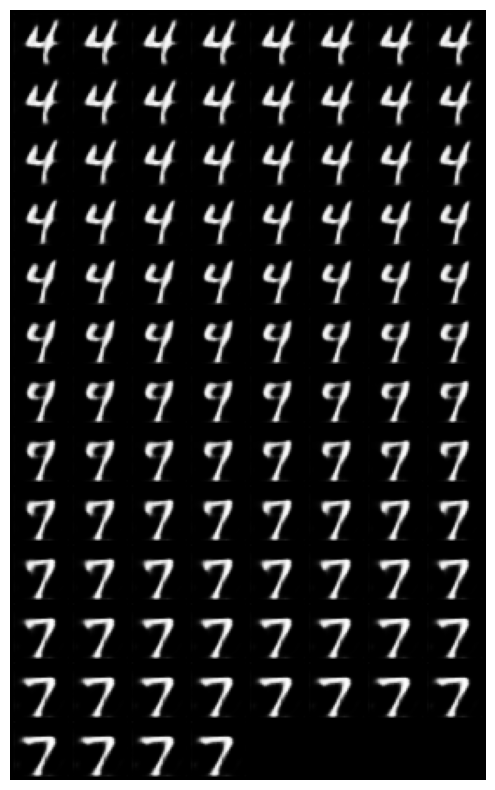

In [42]:
plt.figure(figsize=(20, 10))
plt.axis(False)
out = vutils.make_grid(recon_steps.detach().cpu(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

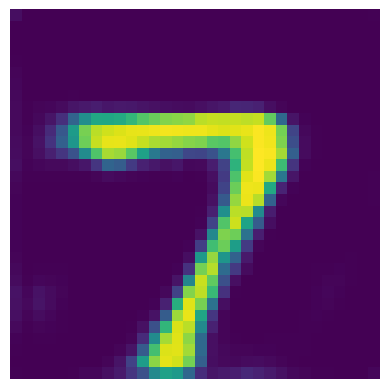

In [48]:
for i in range(num_steps):
    plt.imshow(((recon_steps[i, 0] + 1) / 2).detach().cpu())
    plt.axis(False)
    plt.pause(0.01)
    clear_output(True)